In [1]:
####### LSTM

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(13)
from tensorflow.random import set_seed
set_seed(13)

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("time_series_dataset.csv", sep=";")
dataset.head()

,Data,value
0,2010-01-01,41.651044
1,2010-01-02,131.286604
2,2010-01-03,117.388117
3,2010-01-04,116.461280
4,2010-01-05,123.823765


In [3]:
dataseries = pd.DataFrame(data=dataset.value.values, index=dataset.Data.values, columns=['value'])
dataseries.head()

,value
2010-01-01,41.651044
2010-01-02,131.286604
2010-01-03,117.388117
2010-01-04,116.461280
2010-01-05,123.823765


In [4]:
train = dataseries[:"2017-12-31"]
test = dataseries["2018-01-01":]

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[0:10]

array([[0.05915337],
       [0.40033012],
       [0.34742879],
       [0.343901  ],
       [0.37192457],
       [0.29755696],
       [0.7683411 ],
       [0.62744752],
       [0.45112936],
       [0.32221339]])

In [6]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [7]:

# define input sequence
raw_seq = scaled_train
# choose a number of time steps
n_steps = 112
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)
print(y.shape)

(2810, 112, 1)
(2810, 1)


In [8]:
# define model
model = Sequential()
model.add(LSTM(200, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200))
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 112, 200)          161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 490,861
Trainable params: 490,861
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit model
model.fit(X, y, epochs=400, batch_size=64, verbose=True)

Epoch 1/400
2810/2810 [==============================] - 25s 9ms/step - loss: 0.0185
Epoch 2/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0083
Epoch 3/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0062
Epoch 4/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0059
Epoch 5/400
2810/2810 [==============================] - 24s 8ms/step - loss: 0.0059
Epoch 6/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0058
Epoch 7/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0057
Epoch 8/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0055
Epoch 9/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0056
Epoch 10/400
2810/2810 [==============================] - 23s 8ms/step - loss: 0.0056
Epoch 11/400
2810/2810 [==============================] - 24s 8ms/step - loss: 0.0055
Epoch 12/400
2810/2810 [==============================] - 24s 9

In [10]:
model.save('LSTMmodel')

In [11]:
# demonstrate 1 prediction
x_input = array(scaled_test[-(n_steps):])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)
print(scaled_test[len(scaled_test)-1])

[[0.34149674]]
[0.35000168]


In [12]:
yhat.shape

(1, 1)

In [13]:
# generate predictions for 2018 (365 days)
horizon = 365
forecasts2018 = []
raw_seq = scaled_test
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))


for i in range(horizon):
  yhat = model.predict(X, verbose=0)
  forecasts2018.append(yhat[len(yhat)-1])
  apoyo = raw_seq[1:]
  raw_seq[horizon-1] = yhat[len(yhat)-1]
  raw_seq[0:horizon-1] = apoyo
  X, y = split_sequence(raw_seq, n_steps)
  X = X.reshape((X.shape[0], X.shape[1], n_features))


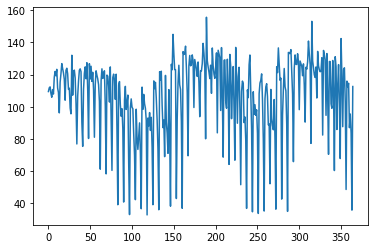

In [17]:
plt.plot(scaler.inverse_transform(forecasts2018))
plt.savefig('forecast2018.png')

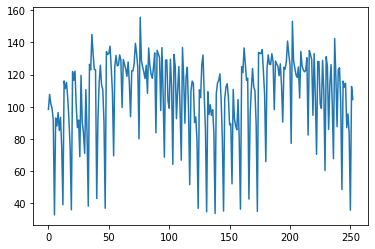

In [18]:
raw_seq = scaled_test
# choose a number of time steps
n_steps = 112
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

roll_forecast = model.predict(X)
plt.plot(scaler.inverse_transform(roll_forecast))
plt.savefig('roll_forecast2018.png')

In [19]:
# re-extimate model on whole data for 2019 forecast

# re-define input sequence
scaler.fit(dataseries)
raw_seq = scaler.transform(dataseries)
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))


# re-define model
model = Sequential()
model.add(LSTM(200, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200))
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

# re-fit model
model.fit(X, y, epochs=400, batch_size=64, verbose=True)


Epoch 1/400
3175/3175 [==============================] - 27s 8ms/step - loss: 0.0169
Epoch 2/400
3175/3175 [==============================] - 27s 8ms/step - loss: 0.0094
Epoch 3/400
3175/3175 [==============================] - 27s 9ms/step - loss: 0.0068
Epoch 4/400
3175/3175 [==============================] - 27s 8ms/step - loss: 0.0058
Epoch 5/400
3175/3175 [==============================] - 27s 8ms/step - loss: 0.0059
Epoch 6/400
3175/3175 [==============================] - 27s 9ms/step - loss: 0.0059
Epoch 7/400
3175/3175 [==============================] - 27s 9ms/step - loss: 0.0060
Epoch 8/400
3175/3175 [==============================] - 27s 8ms/step - loss: 0.0056
Epoch 9/400
3175/3175 [==============================] - 27s 8ms/step - loss: 0.0054
Epoch 10/400
3175/3175 [==============================] - 27s 9ms/step - loss: 0.0056
Epoch 11/400
3175/3175 [==============================] - 27s 9ms/step - loss: 0.0055
Epoch 12/400
3175/3175 [==============================] - 27s 8

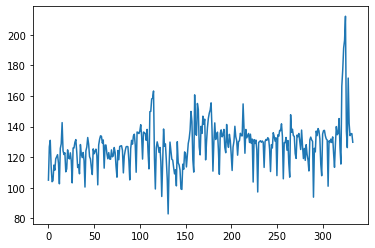

In [21]:
# generate predictions for 2019 (334 days)
horizon = 334
forecasts2019 = []
raw_seq = scaler.transform(dataseries[-horizon:])
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))


for i in range(horizon):
  yhat = model.predict(X, verbose=0)
  forecasts2019.append(yhat[len(yhat)-1])
  apoyo = raw_seq[1:]
  raw_seq[horizon-1] = yhat[len(yhat)-1]
  raw_seq[0:horizon-1] = apoyo
  X, y = split_sequence(raw_seq, n_steps)
  X = X.reshape((X.shape[0], X.shape[1], n_features))

plt.plot(scaler.inverse_transform(forecasts2019))

In [30]:
pd.DataFrame.to_csv(pd.DataFrame(scaler.inverse_transform(forecasts2018)), "2018LSTMforecast.csv")
pd.DataFrame.to_csv(pd.DataFrame(scaler.inverse_transform(forecasts2019)), "2019LSTMforecast.csv")

In [23]:
model.save('LSTMmodel2')

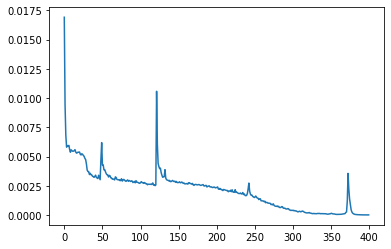

In [27]:
loss_optim = model.history
plt.plot(loss_optim.history['loss'])
plt.savefig('loss_optimization_final.png')

In [28]:
from google.colab import files
files.download('LSTMmodel2')

In [31]:
files.download('2018LSTMforecast.csv')
files.download('2019LSTMforecast.csv')
#files.download('loss_optimization_final.png')